## 正则化和激活函数探索

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import random


# 设置随机种子
def set_seed(seed=42):
    # 设置随机种子
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # 如果使用CUDA
    torch.mps.manual_seed(seed)       # 如果使用MPS (Apple Silicon)
    np.random.seed(seed)
    random.seed(seed)
    
    # 确保卷积运算的确定性
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 激活函数实验

激活函数是神经网络中的重要组成部分，它为网络引入非线性变换能力。本实验将探索三种常见的激活函数(ReLU、Sigmoid、Tanh)的特性及其对模型训练的影响。

### 激活函数的实现与可视化

首先我们实现这三个激活函数及其导数，并通过可视化来理解它们的特性：

- ReLU: f(x) = max(0,x)
- Sigmoid: f(x) = 1/(1+e^(-x))  
- Tanh: f(x) = (e^x - e^(-x))/(e^x + e^(-x))

In [13]:

def check_activation_function(MyReLU,MySigmoid,MyTanh):
    x = torch.linspace(-10, 10, 1000)

    # 使用自己实现的激活函数
    my_relu = MyReLU()
    my_sigmoid = MySigmoid()
    my_tanh = MyTanh()

    # 计算激活函数值和导数值
    y_my_relu = my_relu(x)
    y_my_sigmoid = my_sigmoid(x)
    y_my_tanh = my_tanh(x)

    y_my_relu_derivative = my_relu.derivative(x)
    y_my_sigmoid_derivative = my_sigmoid.derivative(x)
    y_my_tanh_derivative = my_tanh.derivative(x)
    # 使用PyTorch的激活函数作为参考
    torch_relu = nn.ReLU()
    torch_sigmoid = nn.Sigmoid()
    torch_tanh = nn.Tanh()
    # 验证实现的正确性
    y_torch_relu = torch_relu(x)
    y_torch_sigmoid = torch_sigmoid(x)
    y_torch_tanh = torch_tanh(x)

    # 计算PyTorch激活函数的导数
    x_torch = x.clone().requires_grad_(True)  # 使x支持求导

    # ReLU导数
    y_torch_relu = torch_relu(x_torch)
    y_torch_relu.sum().backward()
    y_torch_relu_derivative = x_torch.grad.clone()
    x_torch.grad = None  # 清除梯度

    # Sigmoid导数
    y_torch_sigmoid = torch_sigmoid(x_torch)
    y_torch_sigmoid.sum().backward()
    y_torch_sigmoid_derivative = x_torch.grad.clone()
    x_torch.grad = None

    # Tanh导数
    y_torch_tanh = torch_tanh(x_torch)
    y_torch_tanh.sum().backward()
    y_torch_tanh_derivative = x_torch.grad.clone()

    assert torch.allclose(y_my_relu, y_torch_relu, rtol=1e-4, atol=1e-4), "ReLU实现有误"
    assert torch.allclose(y_my_sigmoid, y_torch_sigmoid, rtol=1e-4, atol=1e-4), "Sigmoid实现有误"
    assert torch.allclose(y_my_tanh, y_torch_tanh, rtol=1e-4, atol=1e-4), "Tanh实现有误"

    assert torch.allclose(y_my_relu_derivative, y_torch_relu_derivative, rtol=1e-4, atol=1e-4), "ReLU导数实现有误"
    assert torch.allclose(y_my_sigmoid_derivative, y_torch_sigmoid_derivative, rtol=1e-4, atol=1e-4), "Sigmoid导数实现有误"
    assert torch.allclose(y_my_tanh_derivative, y_torch_tanh_derivative, rtol=1e-4, atol=1e-4), "Tanh导数实现有误"

    # 绘制激活函数和导数
    plt.figure(figsize=(15, 6))

    # 绘制激活函数
    plt.subplot(1, 2, 1)
    plt.plot(x.numpy(), y_my_relu.numpy(), label='ReLU')
    plt.plot(x.numpy(), y_my_sigmoid.numpy(), label='Sigmoid')
    plt.plot(x.numpy(), y_my_tanh.numpy(), label='Tanh')
    plt.title('Activation Functions')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)

    # 绘制导数
    plt.subplot(1, 2, 2)
    plt.plot(x.numpy(), y_my_relu_derivative.numpy(), label='ReLU\'')
    plt.plot(x.numpy(), y_my_sigmoid_derivative.numpy(), label='Sigmoid\'')
    plt.plot(x.numpy(), y_my_tanh_derivative.numpy(), label='Tanh\'')
    plt.title('Derivatives of Activation Functions')
    plt.xlabel('x')
    plt.ylabel('y\'')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

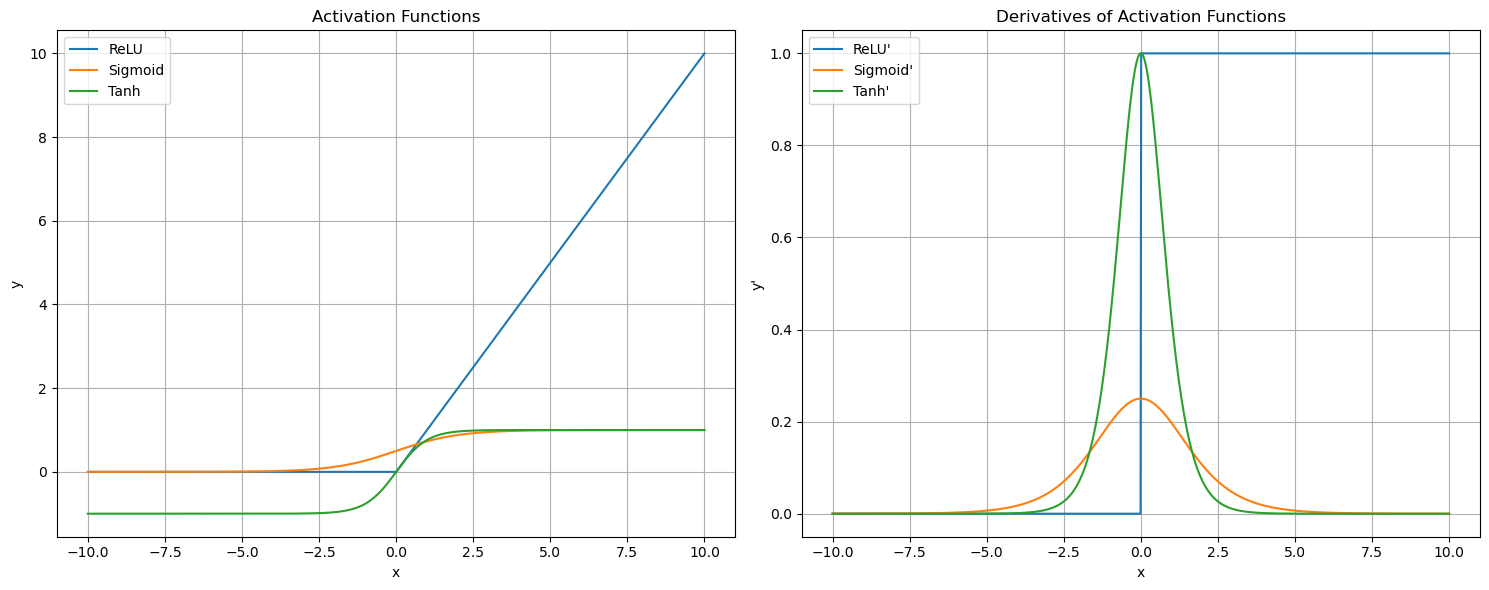

In [14]:
# 自己实现激活函数及其导数
class MyReLU:
    def __call__(self, x):
        """实现ReLU激活函数: f(x) = max(0, x)"""
        return torch.maximum(torch.tensor(0), x)
    
    def derivative(self, x):
        """ReLU的导数: f'(x) = 1 if x > 0 else 0"""
        return torch.where(x > 0, torch.tensor(1.0), torch.tensor(0.0))

class MySigmoid:
    def __call__(self, x):
        """实现Sigmoid激活函数: f(x) = 1 / (1 + e^(-x))"""
        return 1 / (1 + torch.exp(-x))

    def derivative(self, x):
        """Sigmoid的导数: f'(x) = f(x) * (1 - f(x))"""
        sigmoid_x = self.__call__(x)
        return sigmoid_x * (1 - sigmoid_x)

class MyTanh:
    def __call__(self, x):
        """实现Tanh激活函数: f(x) = (e^x - e^(-x)) / (e^x + e^(-x))"""
        return (torch.exp(x) - torch.exp(-x)) / (torch.exp(x) + torch.exp(-x))
        
    
    def derivative(self, x):
        """Tanh的导数: f'(x) = 1 - f(x)^2"""
        tanh_x = self.__call__(x)
        return 1 - tanh_x ** 2

# 测试实现的激活函数

check_activation_function(MyReLU,MySigmoid,MyTanh)

思考题1：为什么神经网络需要非线性激活函数？如果使用线性激活函数会发生什么？

 ### 梯度消失问题实验

梯度消失是深度神经网络训练中的一个常见问题。当网络层数较深时，在反向传播过程中梯度会随着层数的增加而逐渐减小，导致靠近输入层的参数几乎无法更新。本实验将：

1. 构建一个多层神经网络
2. 分别使用不同激活函数(ReLU、Sigmoid、Tanh)
3. 观察训练过程中各层的梯度分布
4. 分析不同激活函数对梯度消失问题的影响

In [15]:
# 1. 梯度消失实验的网络
class Network(nn.Module):
    def __init__(self, input_dim, output_dim, activation_name, num_layers=5):
        super(Network, self).__init__()
        self.layers = nn.ModuleList()
        self.input_dim = input_dim
        
        # 创建很深的网络来测试梯度问题
        for _ in range(num_layers):
            self.layers.append(nn.Linear(100, 100))

        if activation_name == 'relu': 
            self.activation = MyReLU()
        elif activation_name == 'sigmoid':
            self.activation = MySigmoid()
        elif activation_name == 'tanh':
            self.activation = MyTanh()
        self.input_layer = nn.Linear(input_dim, 100)
        self.output_layer = nn.Linear(100, output_dim)

    def forward(self, x):
        # TODO: 实现前向传播函数
        # 1. 首先通过输入层
        # 2. 应用激活函数
        # 3. 依次通过每个隐藏层并应用激活函数
        # 4. 最后通过输出层返回结果
        x = self.input_layer(x)
        x = self.activation(x)
        for layer in self.layers:
            x = layer(x)
            x = self.activation(x)
        x = self.output_layer(x)
        return x



In [16]:
def analyze_gradients(model):
    """分析模型各层的梯度分布"""
    set_seed()
    gradients_by_layer = []
    for name, param in model.named_parameters():
        if param.grad is not None:
            # 计算每层梯度的统计信息
            layer_grads = param.grad.cpu().numpy()
            grad_mean = np.mean(np.abs(layer_grads))
            grad_std = np.std(layer_grads)
            gradients_by_layer.append({
                'layer': name,
                'mean': grad_mean,
                'std': grad_std
            })
    return gradients_by_layer

In [17]:
def get_data(batch_size=64):
    # 准备数据
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    
    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST('./data', train=False, transform=transform)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader,test_loader
    
def plot_results(results):
    # 绘制结果
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # 绘制准确率随epoch变化
    for activation in results:
        ax1.plot(results[activation]['acc_history'], label=f'{activation}')
    ax1.set_title('Training Accuracy over Epochs')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy (%)')
    ax1.legend()
    ax1.grid(True)
    
    # 绘制最后一个epoch的梯度分布
    for activation in results:
        last_grads = results[activation]['grad_history'][-1]
        ax2.semilogy(last_grads, label=f'{activation}')
    ax2.set_title('Gradient Distribution (Last Epoch)')
    ax2.set_xlabel('Layer Index')
    ax2.set_ylabel('Gradient Mean (log scale)')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

Activation: relu, Epoch: 0, Accuracy: 15.65%
Activation: relu, Epoch: 1, Accuracy: 25.12%
Activation: relu, Epoch: 2, Accuracy: 38.26%
Activation: relu, Epoch: 3, Accuracy: 59.08%
Activation: relu, Epoch: 4, Accuracy: 68.40%
Activation: sigmoid, Epoch: 0, Accuracy: 10.29%
Activation: sigmoid, Epoch: 1, Accuracy: 11.24%
Activation: sigmoid, Epoch: 2, Accuracy: 11.24%
Activation: sigmoid, Epoch: 3, Accuracy: 11.24%
Activation: sigmoid, Epoch: 4, Accuracy: 11.24%
Activation: tanh, Epoch: 0, Accuracy: 41.18%
Activation: tanh, Epoch: 1, Accuracy: 64.39%
Activation: tanh, Epoch: 2, Accuracy: 71.09%
Activation: tanh, Epoch: 3, Accuracy: 77.74%
Activation: tanh, Epoch: 4, Accuracy: 81.82%


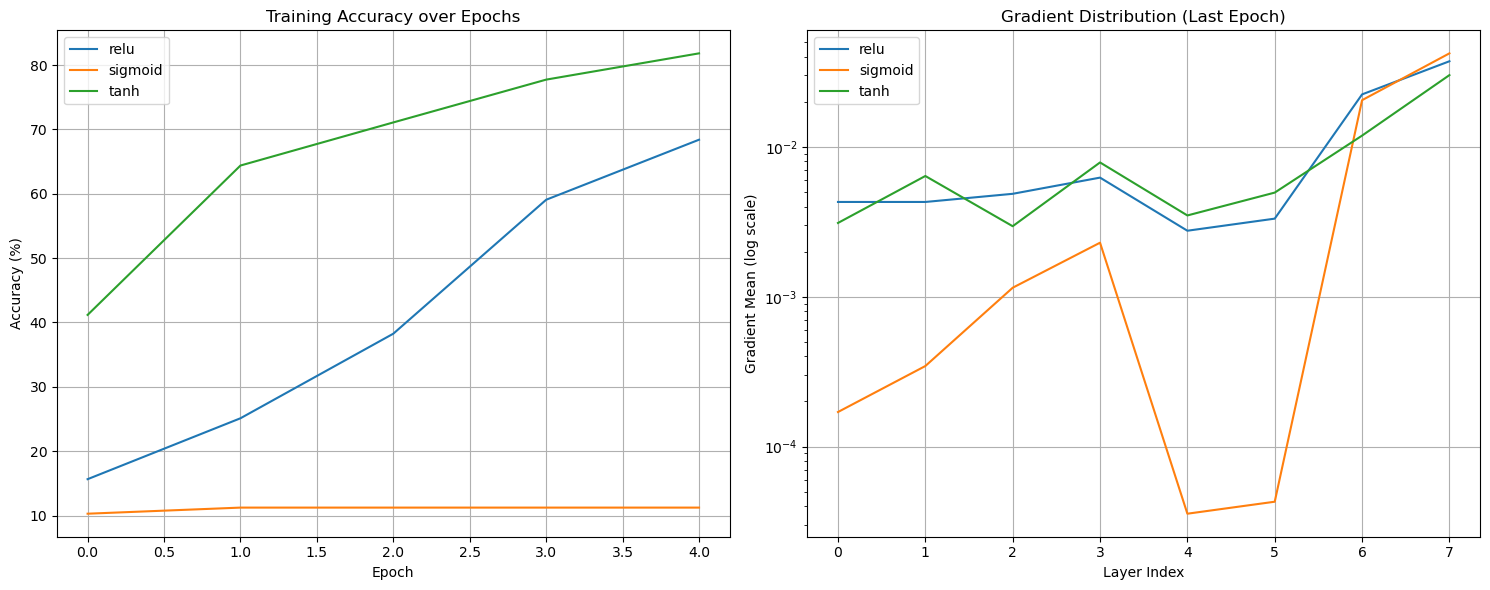

In [18]:

def experiment_gradient_vanishing():
    """梯度消失实验"""
    set_seed()
    criterion = nn.CrossEntropyLoss()
    # 训练不同激活函数的深层网络
    results = {activation: {'acc_history': [], 'grad_history': []} for activation in ['relu', 'sigmoid', 'tanh']}
    
    n_epochs = 5
    for activation in ['relu','sigmoid', 'tanh']:
        train_loader,_ = get_data()
        model = Network(input_dim=784, output_dim=10, activation_name=activation,num_layers=2).to(device)
        optimizer = optim.SGD(model.parameters(), lr=0.001)
        
        for epoch in range(n_epochs):
            model.train()
            total_loss = 0
            correct = 0
            total = 0
            
            # 训练阶段
            for batch_idx, (data, target) in enumerate(train_loader):
                data, target = data.to(device), target.to(device)
                data = data.view(data.size(0), -1)
                
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                
                # 收集梯度信息
                if batch_idx % 1 == 0:
                    gradients = analyze_gradients(model)
                    results[activation]['grad_history'].append(
                        [g['mean'] for g in gradients]
                    )
                
                optimizer.step()
                
                # 计算准确率
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
                total += target.size(0)
                total_loss += loss.item()
            
            # 计算epoch的平均准确率
            epoch_acc = 100. * correct / total
            results[activation]['acc_history'].append(epoch_acc)
            print(f'Activation: {activation}, Epoch: {epoch}, Accuracy: {epoch_acc:.2f}%')

    plot_results(results)

experiment_gradient_vanishing()


思考题2：观察实验结果，为什么训练准确率会和激活函数选择相关？这与梯度分布有什么关系？

提示：
- 比较不同激活函数的梯度范围
- 分析梯度消失对模型训练的影响
- 思考为什么ReLU在深度学习中更受欢迎

### ReLU死亡现象实验

ReLU死亡现象指神经元在训练过程中持续输出0，导致参数无法更新的问题。本实验将：

1. 统计使用ReLU和Tanh激活函数时的神经元激活情况
2. 分析ReLU死亡现象的产生原因
3. 探讨如何缓解这一问题


Activation: relu, Epoch 0: Death Rate: 0.50%
Activation: relu, Epoch 1: Death Rate: 0.49%
Activation: relu, Epoch 2: Death Rate: 0.48%
Activation: relu, Epoch 3: Death Rate: 0.48%
Activation: relu, Epoch 4: Death Rate: 0.48%
Activation: tanh, Epoch 0: Death Rate: 0.00%
Activation: tanh, Epoch 1: Death Rate: 0.00%
Activation: tanh, Epoch 2: Death Rate: 0.00%
Activation: tanh, Epoch 3: Death Rate: 0.00%
Activation: tanh, Epoch 4: Death Rate: 0.00%


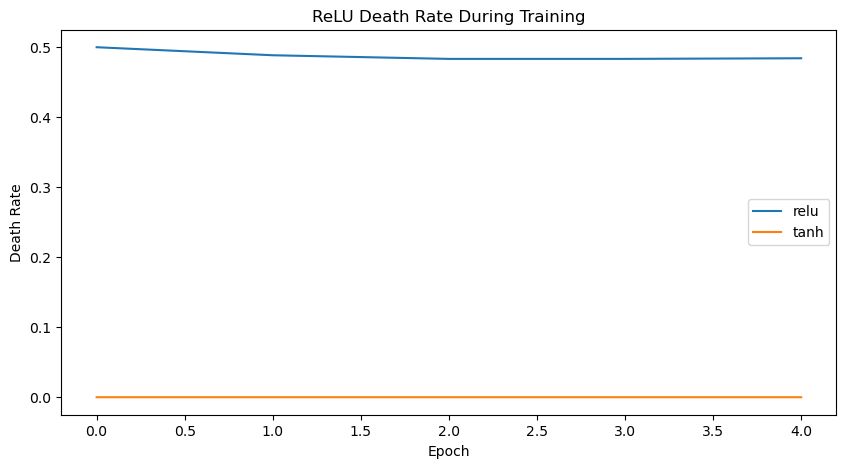

In [19]:
def experiment_relu_death():
    """ReLU死亡现象实验"""
    set_seed()
    criterion = nn.CrossEntropyLoss()
    # 比较ReLU和LeakyReLU
    activation_counts = {'relu': [], 'tanh': []}
    
    for activation in ['relu', 'tanh']:
        model = Network(input_dim=784, output_dim=10, activation_name=activation, num_layers=2).to(device)
        optimizer = optim.SGD(model.parameters(), lr=0.001)
        
        # 训练几个epoch并记录激活值为0的神经元数量
        for epoch in range(5):
            zero_activations = 0
            total_activations = 0
            train_loader,_ = get_data()
            
            for data, target in train_loader:
                data = data.to(device)
                target = target.to(device)
                data = data.view(data.size(0), -1)
                optimizer.zero_grad()
                # 统计死亡神经元
                x = model.input_layer(data)
                x = model.activation(x)
                
                # 记录中间层的激活值
                for layer in model.layers:
                    x = layer(x)
                    activated = model.activation(x)
                    
                    # 统计激活值为0的神经元数量
                    if activation in ['relu', 'tanh']:
                        zero_activations += torch.sum(activated == 0).item()
                        total_activations += activated.numel()
                
                # 继续前向传播完成训练
                output = model.output_layer(x)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
            
            # 计算死亡率
            death_rate = zero_activations / total_activations
            print(f'Activation: {activation}, Epoch {epoch}: Death Rate: {death_rate:.2f}%')
            activation_counts[activation].append(death_rate)
    
    # 绘制死亡率随时间变化
    plt.figure(figsize=(10, 5))
    for activation, rates in activation_counts.items():
        plt.plot(rates, label=activation)
    plt.title('ReLU Death Rate During Training')
    plt.xlabel('Epoch')
    plt.ylabel('Death Rate')
    plt.legend()
    plt.show()

experiment_relu_death()

思考题3：ReLU死亡现象的成因是什么？有哪些解决方案？

提示：
- 分析什么情况下神经元会停止更新
- 思考学习率、初始化方式的影响
- 了解LeakyReLU等变体的优势

 ## 正则化方法实验

过拟合是机器学习中的常见问题，正则化是缓解过拟合的重要手段。本实验将探索两种主要的正则化方法：L2正则化和Dropout。

### L2正则化实验

L2正则化通过在损失函数中添加权重的平方项来限制模型复杂度。本实验将：

1. 构造一个容易过拟合的数据集
2. 实现带有L2正则化的模型训练
3. 对比有无正则化的训练效果
4. 分析L2正则化对模型参数的影响

### L2正则化

**1. 基本概念**
L2正则化(也称为权重衰减)是深度学习中最常用的正则化技术之一。其核心思想是通过限制模型参数的大小来降低模型复杂度，从而防止过拟合。

**2. 数学表达**

在原始损失函数基础上添加L2正则项：

$$L_{total}(\mathbf{w}, b) = L_{original}(\mathbf{w}, b) + \frac{\lambda}{2} \|\mathbf{w}\|^2$$

其中：
- $L_{original}$ 是原始损失函数(如均方误差)
- $\|\mathbf{w}\|^2$ 是权重向量的L2范数平方
- $\lambda$ 是正则化系数，控制正则化的强度

**3. 工作原理**

1. **参数惩罚**：
   - L2正则化通过惩罚较大的权重参数，鼓励模型学习更小的权重值
   - 较大的权重往往意味着模型对输入特征的依赖程度更高，更容易过拟合

2. **平滑效果**：
   - L2正则化倾向于将权重均匀分散到所有特征上
   - 这使得模型不会过分依赖某些特定特征，提高了泛化能力

3. **梯度更新**：
   - 在参数更新时，L2正则化项的梯度为 $\lambda\mathbf{w}$
   - 这相当于在每次更新时将权重缩小一个比例，故称为权重衰减

**4. 与L1正则化的对比**

- L2正则化倾向于产生值较小但非零的权重，权重呈现正态分布
- L1正则化倾向于产生稀疏的权重向量，即许多权重为零
- L2正则化在特征之间有关联时更适用，而L1正则化更适合特征选择

**5. 实践应用**

- 正则化系数 $\lambda$ 是一个需要调整的超参数
- $\lambda = 0$ 时相当于无正则化
- $\lambda$ 越大，正则化效果越强，模型越简单，但可能欠拟合
- 通常通过交叉验证来选择合适的 $\lambda$ 值

#### 数据集定义
给定$x$，我们将**使用以下三阶多项式来生成训练和测试数据的标签：**

**$$y = 0.05 + \sum_{i = 1}^d 0.01 x_i + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.01^2).$$**

我们选择标签是关于输入的线性函数。
标签同时被均值为0，标准差为0.01高斯噪声破坏。
为了使过拟合的效果更加明显，我们可以将问题的维数增加到$d = 200$，
并使用一个只包含20个样本的小训练集。

In [20]:
# 设置维度和样本数
d = 200  # 特征维度
n_train, n_test = 20, 100  # 训练和测试数据集大小

# 生成特征数据
features = np.random.normal(size=(n_train + n_test, d))

# 生成标签
# y = 0.05 + 0.01 * sum(x_i) + epsilon
labels = 0.05 + 0.01 * np.sum(features, axis=1)
# 添加噪声 epsilon ~ N(0, 0.01^2)
labels += np.random.normal(0, 0.01, size=labels.shape)

# 转换为tensor
features = torch.tensor(features, dtype=torch.float32)
labels = torch.tensor(labels, dtype=torch.float32)

# 分割训练集和测试集
train_features = features[:n_train]
test_features = features[n_train:]
train_labels = labels[:n_train]
test_labels = labels[n_train:]

#### **定义$L_2$范数惩罚**

实现这一惩罚最方便的方法是对所有项求平方后并将它们求和。

In [21]:
def l2_penalty(w):
    # TODO: 使用torch.sum和.pow方法实现L2范数惩罚
    # 提示: 对权重参数w平方求和，再除以2
    return torch.sum(w.pow(2)) / 2

#### 对模型进行训练和测试

让我们**实现一个函数来评估模型在给定数据集上的损失**，及**训练函数**。

In [22]:
class Accumulator:
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def evaluate_loss(net, data_iter, loss):
    """评估给定数据集上模型的损失"""
    metric = Accumulator(2)  # 损失的总和,样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

def train_epoch(net, train_iter, loss, trainer, penalty_lambda):
    """训练模型一个epoch"""
    # 将模型设置为训练模式
    net.train()
    # 训练损失总和、训练样本数、实例数
    metric = Accumulator(3)
    for X, y in train_iter:
        trainer.zero_grad()
        y_hat = net(X)
        weight = net[0].weight
        l = loss(y_hat, y.reshape(y_hat.shape)) + penalty_lambda * l2_penalty(weight)
        l.mean().backward()
        trainer.step()
        metric.add(float(l.sum()), y.numel(), 1)
    # 返回训练损失和训练准确率
    return metric[0] / metric[2]

def train(train_features, test_features, train_labels, test_labels,
          num_epochs=100, penalty_lambda=0):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    
    # 创建数据迭代器
    train_iter = DataLoader(
        torch.utils.data.TensorDataset(train_features, train_labels.reshape(-1,1)),
        batch_size=batch_size)
    test_iter = DataLoader(
        torch.utils.data.TensorDataset(test_features, test_labels.reshape(-1,1)),
        batch_size=batch_size)
    
    trainer = torch.optim.SGD(net.parameters(), lr=0.003)
    
    # 记录训练过程
    train_loss = []
    test_loss = []
    
    for epoch in range(num_epochs):
        train_epoch(net, train_iter, loss, trainer, penalty_lambda)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            train_l = evaluate_loss(net, train_iter, loss)
            test_l = evaluate_loss(net, test_iter, loss)
            train_loss.append(train_l)
            test_loss.append(test_l)
            print(f'epoch {epoch+1}, train loss {train_l:.3f}, test loss {test_l:.3f}')
    
    # 绘制损失曲线
    plt.figure(figsize=(10, 6))
    plt.semilogy(range(1, len(train_loss) * 20 + 1, 20), train_loss, label='train')
    plt.semilogy(range(1, len(test_loss) * 20 + 1, 20), test_loss, label='test')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    print('weight:', net[0].weight.data.numpy())

epoch 1, train loss 0.207, test loss 0.269
epoch 20, train loss 0.004, test loss 0.237
epoch 40, train loss 0.000, test loss 0.236
epoch 60, train loss 0.000, test loss 0.235
epoch 80, train loss 0.000, test loss 0.235
epoch 100, train loss 0.000, test loss 0.235


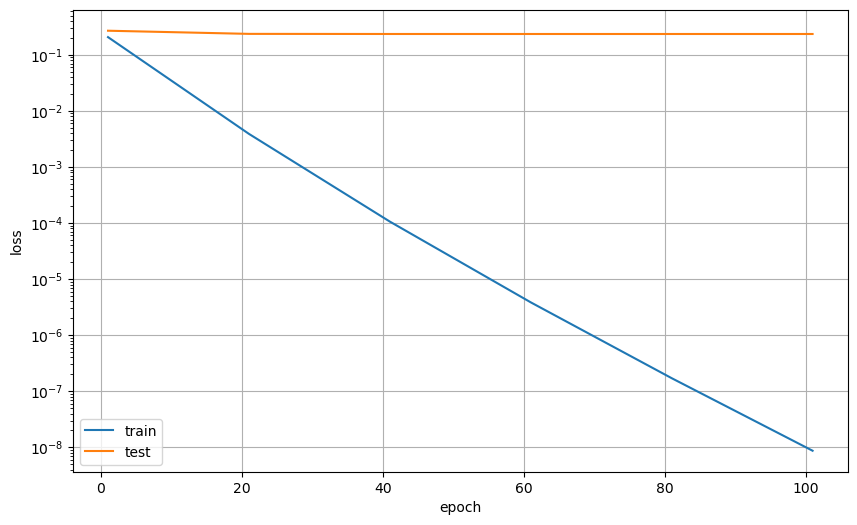

weight: [[ 0.06213367  0.02161987  0.01250468 -0.00038741  0.00026345  0.01882628
   0.01148596 -0.038592    0.07280033  0.02425529 -0.00278562 -0.01042616
   0.00831142  0.0101741  -0.06384518  0.01695499 -0.00261559 -0.04465581
   0.03298909  0.01467113  0.01513677  0.06101429 -0.05472346  0.0274416
   0.02878386 -0.04746002  0.03981642 -0.02157025  0.0537349   0.02950175
   0.02669914  0.01778297  0.0087074  -0.00541574  0.01195018  0.00852684
  -0.02569153 -0.05830128  0.01021804 -0.00945317 -0.01249194 -0.06083682
   0.04345104  0.00401198 -0.03917943  0.03218234  0.01999856  0.01210444
  -0.02958384 -0.04715748  0.07527178  0.0136494  -0.0379831   0.02279778
   0.04228556  0.05617189  0.03144322  0.02550171  0.02976017 -0.03403283
  -0.02303608  0.00286235  0.02898417  0.07230516  0.02544134  0.02275684
   0.01245055 -0.03360707 -0.0040213   0.01002605 -0.0175931   0.01266297
  -0.02223457  0.02708672 -0.02242822  0.01571457  0.01897656  0.01124421
   0.03148175  0.01196408 -0.03

In [23]:
# 不使用正则化
train(train_features, test_features,
      train_labels, test_labels)

epoch 1, train loss 0.227, test loss 0.326
epoch 20, train loss 0.003, test loss 0.155
epoch 40, train loss 0.000, test loss 0.086
epoch 60, train loss 0.000, test loss 0.052
epoch 80, train loss 0.000, test loss 0.035
epoch 100, train loss 0.000, test loss 0.027


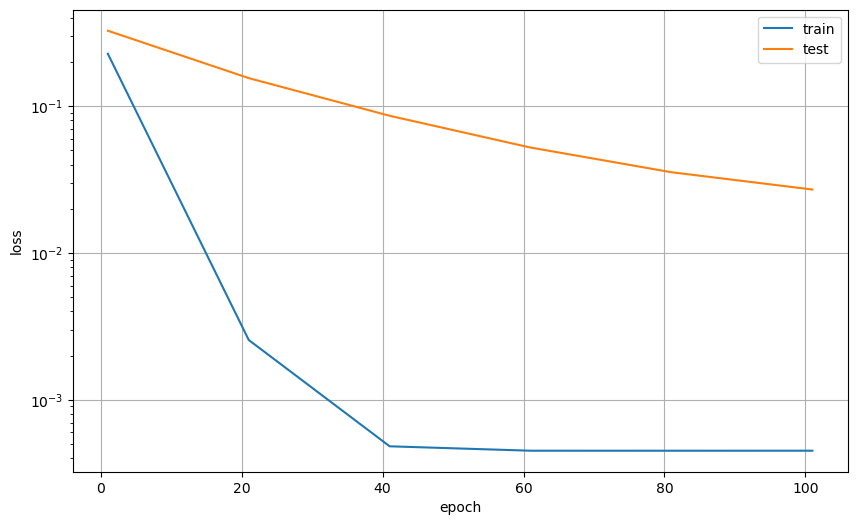

weight: [[ 0.01262724  0.00870728  0.00444747 -0.00869709 -0.01090185 -0.00591271
  -0.00179611  0.00332794  0.00409754  0.00628537 -0.00397796  0.00717943
   0.00628319  0.00711979 -0.00055377  0.00703727  0.00323404 -0.00326099
  -0.01443765 -0.00182255 -0.00210206  0.00696996 -0.00021493  0.00137494
   0.00876674  0.00849671  0.00400869 -0.00843455  0.00049919  0.00993986
  -0.00824383  0.00057956  0.00730221  0.00686361 -0.00525353  0.00119298
  -0.00316807 -0.0091019   0.00953316 -0.00938454 -0.00315622  0.00545347
   0.00022693  0.00775358 -0.00909225  0.00157164 -0.01113372  0.00621301
   0.00760545  0.00612613 -0.00480186  0.00436335 -0.00644546  0.00660414
   0.00444459  0.00192556 -0.01179959 -0.00263234  0.00799278  0.01118612
   0.00426153 -0.00526178 -0.00383784 -0.00015441  0.00917527 -0.00295805
   0.00116117 -0.01192891  0.00085819  0.00011188  0.00503039 -0.0052993
  -0.00550445 -0.00574305  0.00258186  0.00277222 -0.00760298  0.00618506
  -0.00341735  0.00638007  0.00

In [24]:
# 使用L2正则化
train(train_features, test_features,
      train_labels, test_labels, penalty_lambda=3)

#### 简洁实现

在深度学习框架中，我们无需实现L2正则化，只需要在损失函数中添加正则项。


In [25]:

def train_epoch(net, train_iter, loss, trainer):
    """训练模型一个epoch"""
    # 将模型设置为训练模式
    net.train()
    # 训练损失总和、训练样本数、实例数
    metric = Accumulator(3)
    for X, y in train_iter:
        trainer.zero_grad()
        y_hat = net(X)
        weight = net[0].weight
        l = loss(y_hat, y.reshape(y_hat.shape))
        l.mean().backward()
        trainer.step()
        metric.add(float(l.sum()), y.numel(), 1)
    # 返回训练损失和训练准确率
    return metric[0] / metric[2]

def train(train_features, test_features, train_labels, test_labels,
          num_epochs=100, penalty_lambda=0):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    
    # 创建数据迭代器
    train_iter = DataLoader(
        torch.utils.data.TensorDataset(train_features, train_labels.reshape(-1,1)),
        batch_size=batch_size)
    test_iter = DataLoader(
        torch.utils.data.TensorDataset(test_features, test_labels.reshape(-1,1)),
        batch_size=batch_size)
    
    trainer = torch.optim.SGD(net.parameters(), lr=0.003, weight_decay=penalty_lambda)
    
    # 记录训练过程
    train_loss = []
    test_loss = []
    
    for epoch in range(num_epochs):
        train_epoch(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            train_l = evaluate_loss(net, train_iter, loss)
            test_l = evaluate_loss(net, test_iter, loss)
            train_loss.append(train_l)
            test_loss.append(test_l)
            print(f'epoch {epoch+1}, train loss {train_l:.3f}, test loss {test_l:.3f}')
    
    # 绘制损失曲线
    plt.figure(figsize=(10, 6))
    plt.semilogy(range(1, len(train_loss) * 20 + 1, 20), train_loss, label='train')
    plt.semilogy(range(1, len(test_loss) * 20 + 1, 20), test_loss, label='test')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    print('weight:', net[0].weight.data.numpy())

epoch 1, train loss 0.246, test loss 0.364
epoch 20, train loss 0.003, test loss 0.186
epoch 40, train loss 0.001, test loss 0.101
epoch 60, train loss 0.000, test loss 0.059
epoch 80, train loss 0.000, test loss 0.039
epoch 100, train loss 0.000, test loss 0.028


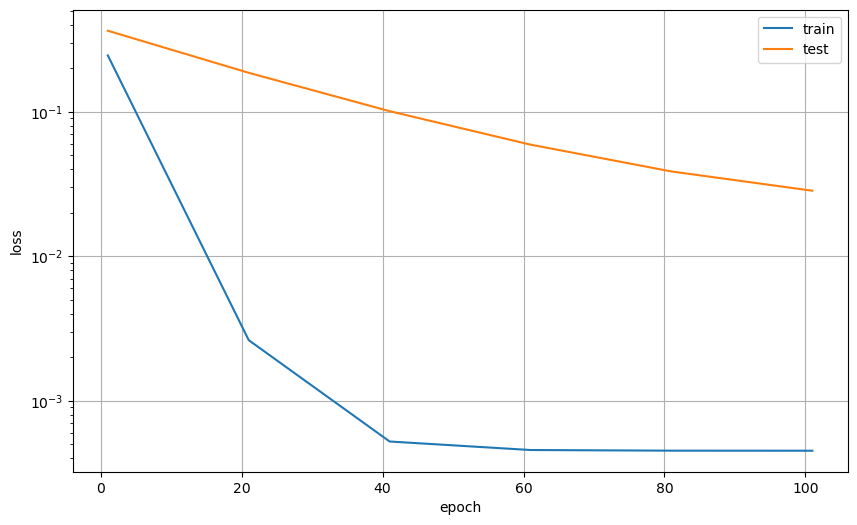

weight: [[ 2.22092112e-05  3.99119500e-03  9.11878981e-03 -1.01228617e-02
   6.21458190e-03 -1.33062536e-02 -1.08955149e-02 -2.49558105e-03
   1.03508336e-02 -9.25414497e-04  1.04194041e-02 -4.38614545e-04
   9.67814773e-03  1.52740465e-03  1.51804648e-03  1.77885480e-02
  -1.08780786e-02  1.15936389e-02 -9.19972453e-03  3.20889591e-03
  -4.11846442e-03  5.46463113e-03  1.24812918e-03  3.68056440e-04
  -6.58623967e-03  7.00210966e-03  6.85294159e-03  3.79991671e-03
  -7.12952903e-03  1.03582372e-03  6.87434711e-03  1.50868285e-03
  -7.22008524e-03  2.70268577e-03 -1.17689809e-02  1.14062326e-02
  -5.11628808e-03 -6.57563237e-03 -5.91779314e-03  1.25441374e-02
   2.48495257e-03  2.09649047e-03 -9.68584605e-03  2.19554361e-03
  -9.68705863e-03 -6.59245707e-04 -8.42487626e-03 -2.84234551e-03
   1.14964037e-04 -8.51626229e-03  6.03658427e-03 -4.38044453e-03
   2.66739563e-03  2.11979123e-03 -4.06442070e-03  8.52322299e-03
   6.80808630e-03  3.49341106e-04 -2.31770752e-03  2.48102500e-04
  

In [26]:
# 使用L2正则化
train(train_features, test_features,
      train_labels, test_labels, penalty_lambda=3)

思考题4：使用L2正则化后，模型的参数会发生什么变化？为什么这种变化有助于防止过拟合？

提示：
- 观察权重的数值分布变化
- 分析正则化系数λ的影响
- 思考为什么较小的权重有助于泛化

### Dropout

*Dropout* 是一种在深度学习中广泛使用的正则化技术。
与L2正则化通过限制权重大小来防止过拟合不同，
Dropout通过在训练过程中随机"丢弃"（设置为零）神经元来实现正则化。

在训练过程中，对于每个样本，每一层的每个神经元都有概率 $p$ 被暂时从网络中移除。
具体来说，如果一个神经元的输出为 $h$，则：

$$
\begin{cases} 
\frac{h}{1-p} & \text{概率 } 1-p \text{ (保留)} \\
0 & \text{概率 } p \text{ (丢弃)}
\end{cases}
$$

这里的 $\frac{1}{1-p}$ 是一个缩放因子，用于保持输出的期望值不变。

Dropout 可以被理解为在训练时集成了多个不同的子网络。
每次前向传播时，由于随机丢弃了一些神经元，
实际上是在训练一个新的子网络。
这些子网络共享参数，但结构各不相同。
在测试时，我们使用完整的网络，但会将所有权重乘以 $(1-p)$ 
来补偿训练时的缩放。

Dropout 的主要优点包括：

1. 防止神经元的共适应性（Co-adaptation）
   - 因为神经元不能依赖于特定的其他神经元的存在
   - 必须学会与随机的神经元子集一起工作

2. 提供了一种廉价的模型集成方法
   - 每次使用Dropout相当于训练一个新的网络架构
   - 最终模型可以看作是多个子网络的集成

3. 减少神经元之间的复杂共适应关系
   - 每个神经元必须学会更鲁棒的特征
   - 不能过分依赖某些特定的特征组合

在实践中，Dropout通常在全连接层中使用，
丢弃概率 $p$ 通常设置为0.5，
而在卷积层中较少使用或使用较小的丢弃概率（如0.1）。

In [27]:

def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    device = X.device
    # TODO: 实现dropout层
    # 1. 如果dropout=1，返回全0张量
    # 2. 如果dropout=0，直接返回输入X
    # 3. 否则，生成一个与X形状相同的随机掩码(mask)
    #    - 使用torch.rand生成随机数，并与dropout比较创建二元掩码
    #    - 将X与掩码相乘，并除以(1-dropout)进行缩放
    # 注意：过程中device参数需要与X的设备相同
    # 在本情况中，所有元素都被丢弃
    if dropout == 1:
        return torch.zeros_like(X, device=device)
    # 在本情况中，所有元素都被保留
    if dropout == 0:
        # TODO: 实现dropout=0的情况
        return X
    # TODO: 实现dropout=其他值的情况
    mask = (torch.rand(X.shape, device=device) > dropout).float()
    return mask * X / (1.0 - dropout)

我们可以通过下面几个例子来**测试`dropout_layer`函数**。
我们将输入`X`通过dropout操作，dropout概率分别为0、0.5和1。


In [28]:
X= torch.arange(16, dtype = torch.float32).reshape((2, 8))
print(X)
print(dropout_layer(X, 0.))
print(dropout_layer(X, 0.5))
print(dropout_layer(X, 1.))

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  2.,  4.,  0.,  0., 10.,  0., 14.],
        [ 0., 18.,  0., 22., 24., 26., 28., 30.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


#### 定义模型

我们可以将dropout应用于每个隐藏层的输出（在激活函数之后），并且dropout只在训练期间有效。


In [29]:
class RegularizedNetwork(nn.Module):
    def __init__(self, dropout_rate=0.0):
        super(RegularizedNetwork, self).__init__()
        self.dropout_rate = dropout_rate
        self.training = True
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(1600, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        if self.training:
            x = dropout_layer(x, self.dropout_rate)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x



Training with No Regularization
Epoch 0: Train Acc: 77.39%, Test Acc: 96.62%
Epoch 1: Train Acc: 97.73%, Test Acc: 98.55%
Epoch 2: Train Acc: 98.51%, Test Acc: 98.37%
Epoch 3: Train Acc: 98.88%, Test Acc: 98.65%
Epoch 4: Train Acc: 99.03%, Test Acc: 98.86%
Epoch 5: Train Acc: 99.26%, Test Acc: 97.97%
Epoch 6: Train Acc: 99.46%, Test Acc: 96.65%
Epoch 7: Train Acc: 99.48%, Test Acc: 98.03%
Epoch 8: Train Acc: 99.58%, Test Acc: 98.88%
Epoch 9: Train Acc: 99.69%, Test Acc: 99.19%
Epoch 10: Train Acc: 99.74%, Test Acc: 99.04%
Epoch 11: Train Acc: 99.83%, Test Acc: 99.13%
Epoch 12: Train Acc: 99.78%, Test Acc: 99.19%
Epoch 13: Train Acc: 99.88%, Test Acc: 99.22%
Epoch 14: Train Acc: 99.92%, Test Acc: 98.95%

Training with Dropout
Epoch 0: Train Acc: 81.43%, Test Acc: 96.83%
Epoch 1: Train Acc: 96.72%, Test Acc: 98.45%
Epoch 2: Train Acc: 97.60%, Test Acc: 98.30%
Epoch 3: Train Acc: 98.16%, Test Acc: 98.82%
Epoch 4: Train Acc: 98.36%, Test Acc: 98.99%
Epoch 5: Train Acc: 98.59%, Test Acc: 9

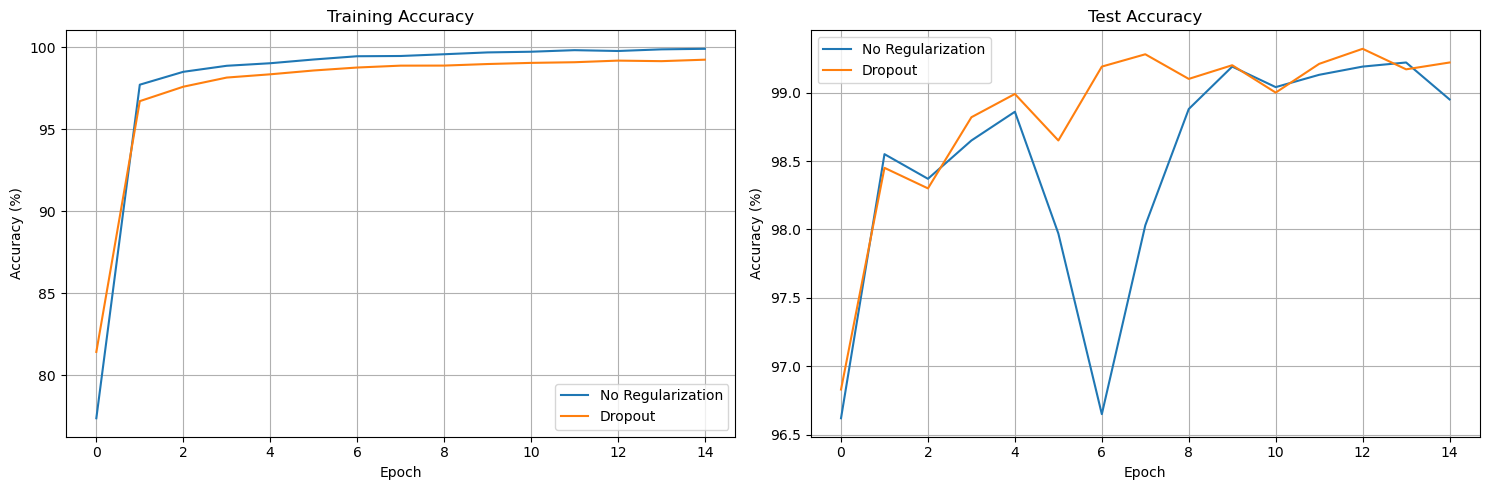

In [30]:

def experiment_regularization():
    """比较不同正则化方法的效果"""
    set_seed()
    # 实验配置
    configs = {
        'No Regularization': {'dropout': 0.0},
        'Dropout': {'dropout': 0.3},
    }
    
    results = {name: {'train_acc': [], 'test_acc': []} for name in configs.keys()}
    n_epochs = 15
    
    for name, config in configs.items():
        print(f"\nTraining with {name}")
        model = RegularizedNetwork(dropout_rate=config['dropout']).to(device)
        
        optimizer = optim.SGD(model.parameters(),lr=0.5)
        criterion = nn.CrossEntropyLoss()
        train_loader,test_loader = get_data(batch_size=256)
        for epoch in range(n_epochs):
            # 训练阶段
            model.train()
            train_correct = 0
            train_total = 0
            for data, target in train_loader:
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
                
                pred = output.argmax(dim=1, keepdim=True)
                train_correct += pred.eq(target.view_as(pred)).sum().item()
                train_total += target.size(0)
            
            train_acc = 100. * train_correct / train_total
            
            # 测试阶段
            model.eval()
            test_correct = 0
            test_total = 0
            
            with torch.no_grad():
                for data, target in test_loader:
                    data, target = data.to(device), target.to(device)
                    output = model(data)
                    pred = output.argmax(dim=1, keepdim=True)
                    test_correct += pred.eq(target.view_as(pred)).sum().item()
                    test_total += target.size(0)
            
            test_acc = 100. * test_correct / test_total
            
            # 记录结果
            results[name]['train_acc'].append(train_acc)
            results[name]['test_acc'].append(test_acc)
            
            print(f'Epoch {epoch}: Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%')
    
    # 绘制结果
    plt.figure(figsize=(15, 5))
    
    # 训练准确率
    plt.subplot(1, 2, 1)
    for name in results:
        plt.plot(results[name]['train_acc'], label=name)
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    # 测试准确率
    plt.subplot(1, 2, 2)
    for name in results:
        plt.plot(results[name]['test_acc'], label=name)
    plt.title('Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# 运行实验
experiment_regularization()

#### Pytorch简洁实现

dropout可以作为`nn.Module`类的一个模块来使用，

```python
nn.Dropout(dropout_rate)
```



Training with No Regularization
Epoch 0: Train Acc: 77.39%, Test Acc: 96.62%
Epoch 1: Train Acc: 97.73%, Test Acc: 98.55%
Epoch 2: Train Acc: 98.51%, Test Acc: 98.37%
Epoch 3: Train Acc: 98.88%, Test Acc: 98.65%
Epoch 4: Train Acc: 99.03%, Test Acc: 98.86%
Epoch 5: Train Acc: 99.26%, Test Acc: 97.97%
Epoch 6: Train Acc: 99.46%, Test Acc: 96.65%
Epoch 7: Train Acc: 99.48%, Test Acc: 98.03%
Epoch 8: Train Acc: 99.58%, Test Acc: 98.88%
Epoch 9: Train Acc: 99.69%, Test Acc: 99.19%
Epoch 10: Train Acc: 99.74%, Test Acc: 99.04%
Epoch 11: Train Acc: 99.83%, Test Acc: 99.13%
Epoch 12: Train Acc: 99.78%, Test Acc: 99.19%
Epoch 13: Train Acc: 99.88%, Test Acc: 99.22%
Epoch 14: Train Acc: 99.92%, Test Acc: 98.95%

Training with Dropout
Epoch 0: Train Acc: 59.08%, Test Acc: 94.59%
Epoch 1: Train Acc: 95.00%, Test Acc: 97.92%
Epoch 2: Train Acc: 96.93%, Test Acc: 98.18%
Epoch 3: Train Acc: 97.61%, Test Acc: 98.27%
Epoch 4: Train Acc: 98.00%, Test Acc: 98.71%
Epoch 5: Train Acc: 98.30%, Test Acc: 9

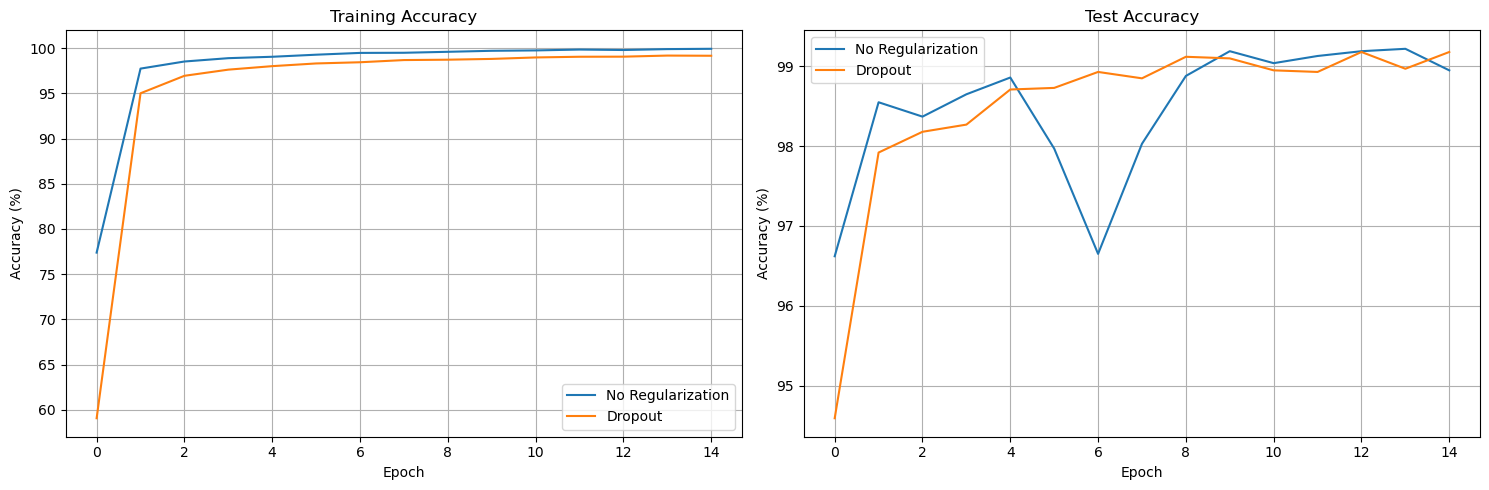

In [31]:
class RegularizedNetwork(nn.Module):
    def __init__(self, dropout_rate=0.0):
        super(RegularizedNetwork, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout = nn.Dropout(dropout_rate) if dropout_rate>0 else None
        self.fc1 = nn.Linear(1600, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        if self.dropout:
            x = self.dropout(x)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

experiment_regularization()


思考题5：Dropout为什么能够起到正则化的作用？训练时和测试时的差异处理有什么意义？

提示：
- 分析Dropout的集成学习观点
- 思考为什么要进行比例缩放
- 考虑Dropout对特征依赖的影响